run from the `scrambler` conda env

In [1]:
import keras
from keras.models import Sequential, Model, load_model

import os
import pickle
import numpy as np
import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from scrambler.models import *
from scrambler.utils import OneHotEncoder, get_sequence_masks
from scrambler.visualizations import plot_dna_logo, plot_dna_importance_scores

#from optimus5_utils import load_optimus5_data, load_optimus5_predictor, animate_optimus5_examples

import utils as u


Using TensorFlow backend.
/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [2]:
# Erin imports
import torch
from itertools import product

SEQ_LEN=8


In [3]:
# pytorch to keras'd deep linear model
k_reload = keras.models.load_model("mer8motif_model_lin_d.h5")

/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
# Load train/test from other notebook
mer8motif_train_df = pd.read_csv("mer8motif_train_df.tsv",sep='\t',index_col=0)
mer8motif_test_df = pd.read_csv("mer8motif_test_df.tsv",sep='\t',index_col=0)

In [5]:
mer8motif_test_df.head()

,seq,score,oh
6,AAAAAACG,18.875,[[1. 0. 0. 0.]\n [1. 0. 0. 0.]\n [1. 0. 0. 0.]...
11,AAAAAAGT,18.125,[[1. 0. 0. 0.]\n [1. 0. 0. 0.]\n [1. 0. 0. 0.]...
17,AAAAACAC,19.250,[[1. 0. 0. 0.]\n [1. 0. 0. 0.]\n [1. 0. 0. 0.]...
21,AAAAACCC,18.875,[[1. 0. 0. 0.]\n [1. 0. 0. 0.]\n [1. 0. 0. 0.]...
24,AAAAACGA,18.875,[[1. 0. 0. 0.]\n [1. 0. 0. 0.]\n [1. 0. 0. 0.]...


In [6]:
# fix OHE parsing
import ast

def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

mer8motif_train_df['oh'] = mer8motif_train_df['oh'].apply(lambda x: from_np_array(x))
mer8motif_test_df['oh'] = mer8motif_test_df['oh'].apply(lambda x: from_np_array(x))

mer8motif_train_df.head()

,seq,score,oh
0,AAAAAAAA,20.000,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [..."
1,AAAAAAAC,19.625,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [..."
2,AAAAAAAG,19.250,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [..."
3,AAAAAAAT,18.875,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [..."
4,AAAAAACA,19.625,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [..."


In [7]:
encoder = OneHotEncoder(seq_length=SEQ_LEN, channel_map={'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3})

# x_train2 = np.array([encoder(seq[0]).flatten().reshape(1, SEQ_LEN, 4) for seq in mer8motif_train_df[['seq']].values])
# x_test2 = np.array([encoder(seq[0]).flatten().reshape(1, SEQ_LEN, 4) for seq in mer8motif_test_df[['seq']].values])

x_train2 = np.array([encoder(seq[0]).reshape(1, SEQ_LEN, 4) for seq in mer8motif_train_df[['seq']].values])
x_test2 = np.array([encoder(seq[0]).reshape(1, SEQ_LEN, 4) for seq in mer8motif_test_df[['seq']].values])

y_train2 = mer8motif_train_df[['score']].values
y_test2 = mer8motif_test_df[['score']].values


# Apparently keras can't deal with training sets that are not 
# an exact multiple of the batch size... sooo... trim some?
train_trim = 12
test_trim = 20

x_train2 = x_train2[:-train_trim]
x_test2 = x_test2[:-test_trim]
y_train2 = y_train2[:-train_trim]
y_test2 = y_test2[:-test_trim]

print(x_train2.shape)
print(y_train2.shape)
print(x_test2.shape)
print(y_test2.shape)


(52416, 1, 8, 4)
(52416, 1)
(13088, 1, 8, 4)
(13088, 1)


In [8]:
# print some example prediction values (should match original pytorch values)
for seq in x_train2[:5]:
    #print(seq)
    #ohe_seq = np.array(u.one_hot_encode(seq))
    #test = np.array(seq.flatten().reshape(1,-1))
    #print(test)
    #print(test.shape)
    res = k_reload.predict(seq)
    print(f"{res[0]}")
    
seqs = ["AAAAAAAA","TTTTTTTT","CCCCCCCC","GGGGGGGG","GGGTATGG","AAGCGAAA"]
for seq in seqs:
    ohe_seq = np.array(torch.tensor(u.one_hot_encode(seq)).unsqueeze(0).float())
    res = k_reload.predict(ohe_seq)
    print(f"{seq}:{res[0]}")

[19.363937]
[19.048687]
[19.090939]
[18.528507]
[19.53384]
AAAAAAAA:[19.363937]
TTTTTTTT:[11.542005]
CCCCCCCC:[17.039753]
GGGGGGGG:[13.53548]
GGGTATGG:[24.622715]
AAGCGAAA:[7.8359823]


In [9]:
#Define sequence template and background

#sequence_template = '$' * 50
sequence_template = '$' * SEQ_LEN

pseudo_count = 1.0

onehot_template = encoder(sequence_template)[None, ...]
sequence_mask = get_sequence_masks([sequence_template])[0]

# This is the background? So it's a mean by position... I'll probs change this...
x_mean = (np.sum(x_train2, axis=(0, 1)) + pseudo_count) / (x_train2.shape[0] + 4. * pseudo_count)
#x_mean = x_mean.reshape(8,4)
#x_mean = np.array([0.25 for x in range(len(sequence_template))])
# ^^ May need to be re-arrayed into SEQLEN x 4??

In [10]:
print(sequence_template)
print(onehot_template)
print(sequence_mask)
print(x_mean)
x_mean.shape

$$$$$$$$
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
[1 1 1 1 1 1 1 1]
[[0.24929416 0.25099199 0.24954216 0.25017169]
 [0.24925601 0.25061045 0.25116368 0.24896986]
 [0.24906524 0.24925601 0.24961847 0.25206028]
 [0.24996185 0.25011446 0.24923693 0.25068676]
 [0.24887448 0.2503243  0.25053415 0.25026707]
 [0.25141167 0.24965662 0.24866463 0.25026707]
 [0.25087753 0.24807325 0.25198398 0.24906524]
 [0.24977108 0.25076307 0.24998092 0.24948493]]


(8, 4)

In [11]:
test = np.array([[.6, .2, .2, .0],
                 [.2, .6, .2, .0],
                 [.0, .2, .2, .6],
                 [.3, .2, .2, .3],
                 [.8, .2, .0, .0],
                 [.0, .2, .2, .8],
                 [.4, .4, .2, .0],
                 [.6, .4, .0, .0],
                ])

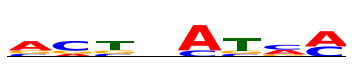

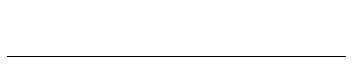

In [12]:
#Visualize background sequence distribution

plot_dna_logo(
    np.copy(test), 
    sequence_template=sequence_template, 
    figsize=(5, 1), logo_height=1.0, 
    plot_start=0, plot_end=SEQ_LEN)

plot_dna_logo(
    np.copy(x_mean), 
    sequence_template=sequence_template, 
    figsize=(5, 1), logo_height=1.0, 
    plot_start=0, plot_end=SEQ_LEN)


In [13]:
#Calculate mean training set kl-divergence against background

# resets one hot to almost 0 and almost 1... why?
#x_train_clipped = np.clip(np.copy(x_train[:, 0, :, :]), 1e-8, 1. - 1e-8)
x_train_clipped = np.clip(np.copy(x_train2[:, 0, :, :]), 1e-8, 1. - 1e-8)

# (train size, 50)
kl_divs = np.sum(x_train_clipped * \
                 np.log(x_train_clipped / np.tile(np.expand_dims(x_mean, axis=0), 
                                                  (x_train_clipped.shape[0], 1, 1))), axis=-1)\
            / np.log(2.0)

# train size
x_mean_kl_divs = np.sum(kl_divs * sequence_mask, axis=-1) / np.sum(sequence_mask)
# 1
x_mean_kl_div = np.mean(x_mean_kl_divs)

print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))


Mean KL Div against background (bits) = 1.9999891911093224


In [14]:
#Build scrambler

# #Scrambler network configuration
# network_config = {
#     'n_groups' : 5,
#     'n_resblocks_per_group' : 4,
#     'n_channels' : 32,
#     'window_size' : 3, 
#     'dilation_rates' : [1, 2, 4, 2, 1],
#     'drop_rate' : 0.0,
#     'norm_mode' : 'instance',
#     'mask_smoothing' : False,
#     'mask_smoothing_window_size' : 5,
#     'mask_smoothing_std' : 1.,
#     'mask_drop_scales' : [1, 5],
#     'mask_min_drop_rate' : 0.0,
#     'mask_max_drop_rate' : 0.5,
#     'label_input' : False
# }

# #Initialize scrambler
# scrambler = Scrambler(
#     scrambler_mode='inclusion',
#     input_size_x=1,
#     input_size_y=50,
#     n_out_channels=4,
#     input_templates=[onehot_template],
#     input_backgrounds=[x_mean],
#     batch_size=32,
#     n_samples=32,
#     sample_mode='gumbel',
#     zeropad_input=False,
#     mask_dropout=False,
#     network_config=network_config
# )

#Scrambler network configuration
network_config = {
    'n_groups' : 1,
    'n_resblocks_per_group' : 1, # resblock has 2 conv layers
    'n_channels' : 32, # num filters
    'window_size' : 3, # kernel size
    'dilation_rates' : [1],
    'drop_rate' : 0.0,
    'norm_mode' : 'instance', # some sort of normalization
    'mask_smoothing' : False, # "smooth" not referenced in paper or github instructions
    'mask_smoothing_window_size' : 5,
    'mask_smoothing_std' : 1.,
    'mask_drop_scales' : [1, 5],
    'mask_min_drop_rate' : 0.0,
    'mask_max_drop_rate' : 0.5,
    'label_input' : False
}

#Initialize scrambler
scrambler = Scrambler(
    scrambler_mode='inclusion',
    input_size_x=1,
    input_size_y=SEQ_LEN,
    n_out_channels=4,
    input_templates=[onehot_template],
    input_backgrounds=[x_mean],
    batch_size=32,
    n_samples=32,
    sample_mode='gumbel',
    zeropad_input=False,
    mask_dropout=False,
    network_config=network_config
)


SCRAMBLER INITIATED!!

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [15]:
scrambler

In [16]:
#Train scrambler

n_epochs = 10

# train_history = scrambler.train(
#     predictor,
#     x_train,
#     y_train,
#     x_test,
#     y_test,
#     n_epochs,
#     monitor_test_indices=np.arange(32).tolist(),
#     monitor_batch_freq_dict={0 : 1, 100 : 5, 469 : 10},
#     nll_mode='reconstruction',
#     predictor_task='regression',
#     entropy_mode='target',
#     entropy_bits=0.125,
#     entropy_weight=10.
# )

train_history = scrambler.train(
    k_reload,
    x_train2,
    y_train2,
    x_test2,
    y_test2,
    n_epochs,
    monitor_test_indices=np.arange(32).tolist(),
    monitor_batch_freq_dict={0 : 1, 100 : 5, 469 : 10},
    nll_mode='reconstruction',
    predictor_task='regression',
    entropy_mode='target',
    entropy_bits=0.125,
    entropy_weight=10.
)


IN SCRAMBLER TRAIN!
predictor is compiled??
Scrambler has created inputs...
Starting to build lambda stuff?
About to predict stuff...
Inflating?
Calculating NLL / error?
Calculated NLL?: Tensor("nll/mul:0", shape=(32,), dtype=float32)
Made Loss Model
Compiled loss model: <keras.engine.training.Model object at 0x7f649c31fa90>
label train and test? [] []
APPENDING to callbacks
Fitting loss model...
	group train 1 (52416, 1)
	x train 1 (52416, 1, 8, 4)
	drop train 0 []
	label train 0 []

n epochs: 10
batch size: 32
callbacks: [<scrambler.models.scrambler_models.ScramblerMonitor object at 0x7f649425e750>]
Train on 52416 samples, validate on 13088 samples
Epoch 1/10
52416/52416 [==============================] - 36s 694us/step - loss: 18.2373 - nll_loss: 9.8817 - entropy_loss: 8.3556 - val_loss: 15.3427 - val_nll_loss: 8.2126 - val_entropy_loss: 7.1301
Epoch 2/10
52416/52416 [==============================] - 32s 607us/step - loss: 14.6175 - nll_loss: 7.5567 - entropy_loss: 7.0608 - val_los

In [17]:
#Save scrambler checkpoint
save_dir = 'saved_models'

#model_name = 'optimus5_inclusion_scrambler_bits_0125_epochs_10'
model_name = 'mer8motif_model_lin_d_inclusion_scrambler_bits_0125_epochs_10'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler.save_model(model_path)

pickle.dump({'train_history' : train_history}, open(save_dir + '/' + model_name + '_train_history.pickle', 'wb'))


Saved scrambler model at saved_models/mer8motif_model_lin_d_inclusion_scrambler_bits_0125_epochs_10.h5 


In [20]:
# #Load models
# save_dir = 'saved_models'

# model_name = 'optimus5_inclusion_scrambler_bits_0125_epochs_10'

# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)

# model_path = os.path.join(save_dir, model_name + '.h5')

# scrambler.load_model(model_path)


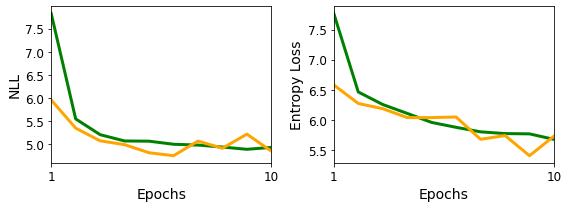

In [21]:
#Plot training statistics

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 4, 3))

n_epochs_actual = len(train_history['nll_loss'])

ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['nll_loss'], linewidth=3, color='green')
ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['val_nll_loss'], linewidth=3, color='orange')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['entropy_loss'], linewidth=3, color='green')
ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['val_entropy_loss'], linewidth=3, color='orange')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()

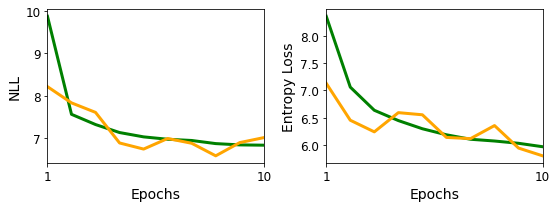

In [18]:
#Plot training statistics

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 4, 3))

n_epochs_actual = len(train_history['nll_loss'])

ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['nll_loss'], linewidth=3, color='green')
ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['val_nll_loss'], linewidth=3, color='orange')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['entropy_loss'], linewidth=3, color='green')
ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['val_entropy_loss'], linewidth=3, color='orange')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()

In [19]:
#Interpret the test set using the trained scrambler

pwm_test, sample_test, importance_scores_test = scrambler.interpret(x_test2)


13088/13088 [==============================] - 2s 168us/step


In [20]:
print("x_test2:",x_test2.shape)
print("pwm_test:",pwm_test.shape)
print("sample_test:",sample_test.shape)
print("importance_scores_test:",importance_scores_test.shape)

x_test2: (13088, 1, 8, 4)
pwm_test: (13088, 1, 8, 4)
sample_test: (13088, 32, 1, 8, 4)
importance_scores_test: (13088, 1, 8, 1)


In [21]:
# get seqs from test df that are ineresting to spot check
test_df = mer8motif_test_df.reset_index()

tat = list(test_df[test_df['seq'].str.contains("TAT")].index)
gcg = list(test_df[test_df['seq'].str.contains("GCG")].index)

print("Num TAT:",len(tat))
print("Num TAT:",len(gcg))

Num TAT: 1146
Num TAT: 1124


In [22]:
# Show some examples
list_idx = 2
g = gcg[list_idx]
print(f'GCG example idx {g}: {test_df.loc[g]["seq"]}')

list_idx = 1145
t = tat[list_idx]
print(f'TAT example idx {t}: {test_df.loc[t]["seq"]}')

GCG example idx 133: AAAGCGAA
TAT example idx 13074: TTTTATAG


In [23]:
# some idxs I checked and think are interesting?
ixs = [4,133,97,99,13074,13075,578,579,438,439]

Test sequence 4:
 - Prediction (original) = 18.9
 - Predictions (scrambled) = [16.6, 15.8, 17.7, 16.0, 13.5, 18.2, 16.5, 15.6, 18.2, 16.3, 15.2, 15.1, 15.6, 18.2, 17.7, 14.0, 17.0, 16.4, 15.1, 14.7, 17.8, 16.5, 17.0, 17.2, 16.7, 15.8, 18.5, 17.3, 16.4, 14.8, 15.3, 16.3]


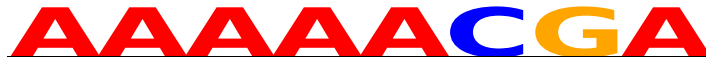

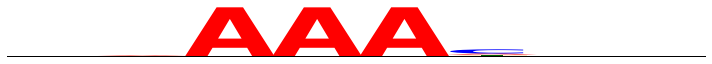

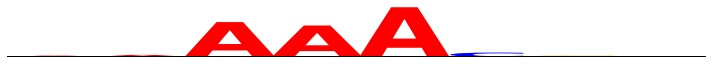

Test sequence 133:
 - Prediction (original) = 8.09
 - Predictions (scrambled) = [4.71, 6.94, 6.2, 3.97, 5.44, -0.0, 5.86, 6.42, 2.35, 4.85, 4.93, 4.75, 3.82, 6.14, 5.2, 5.65, 5.68, 1.97, 5.23, 5.22, 3.7, 3.3, 6.01, 4.65, 5.21, 5.23, 5.68, 6.42, 6.56, 5.41, 6.0, 4.76]


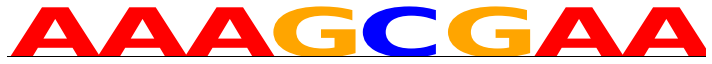

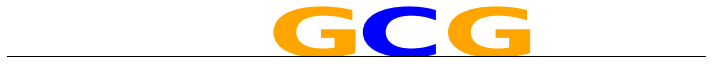

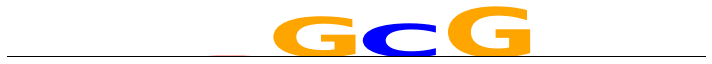

Test sequence 97:
 - Prediction (original) = 26.9
 - Predictions (scrambled) = [25.4, 25.6, 26.1, 24.7, 26.1, 25.4, 25.0, 26.6, 24.1, 25.8, 25.4, 25.5, 26.1, 25.2, 26.0, 23.8, 25.2, 23.5, 25.2, 25.7, 25.1, 24.6, 24.8, 25.8, 25.4, 24.2, 24.2, 26.1, 24.9, 25.6, 26.6, 25.1]


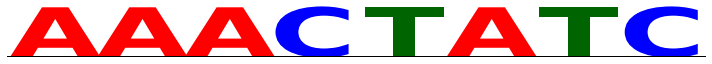

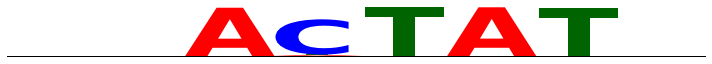

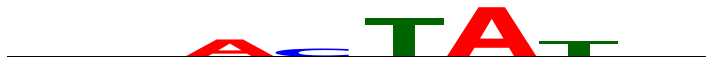

Test sequence 99:
 - Prediction (original) = 18.9
 - Predictions (scrambled) = [16.2, 16.7, 16.8, 16.5, 16.7, 13.7, 16.5, 14.4, 14.6, 16.5, 16.9, 17.4, 17.2, 14.5, 18.0, 15.9, 17.5, 15.8, 16.9, 17.1, 14.7, 15.4, 15.7, 16.5, 17.0, 15.4, 15.8, 17.3, 13.6, 16.3, 17.2, 17.3]


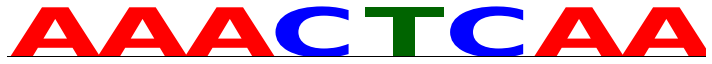

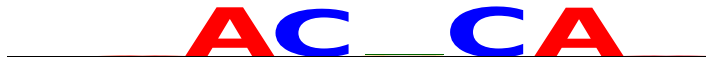

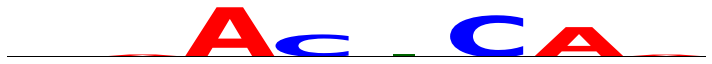

Test sequence 13074:
 - Prediction (original) = 21.7
 - Predictions (scrambled) = [23.9, 22.6, 23.4, 24.2, 24.6, 24.0, 25.1, 23.0, 24.5, 23.6, 22.6, 22.9, 23.0, 22.3, 25.0, 23.4, 24.7, 23.5, 23.9, 23.2, 23.6, 21.7, 23.4, 22.3, 23.2, 22.7, 22.4, 22.2, 25.0, 24.0, 22.9, 24.0]


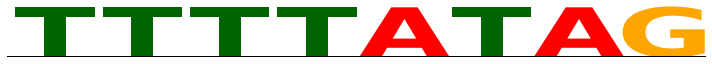

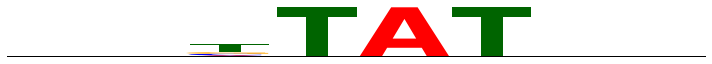

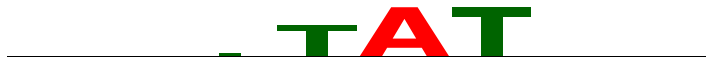

Test sequence 13075:
 - Prediction (original) = 13.4
 - Predictions (scrambled) = [14.3, 14.1, 14.4, 14.7, 13.6, 13.6, 16.1, 13.8, 14.9, 14.3, 15.6, 13.2, 15.2, 14.8, 14.6, 14.9, 15.0, 15.1, 14.2, 13.7, 14.7, 15.7, 15.5, 14.6, 13.9, 13.9, 13.9, 14.8, 14.9, 13.5, 15.1, 14.9]


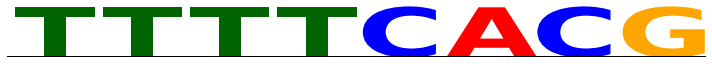

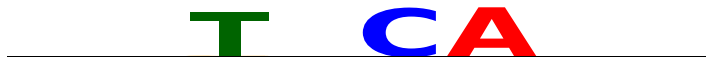

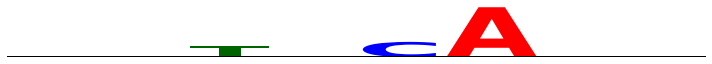

Test sequence 578:
 - Prediction (original) = 24.7
 - Predictions (scrambled) = [22.9, 22.9, 20.1, 19.1, 21.7, 23.3, 21.0, 22.3, 21.6, 23.7, 23.9, 22.4, 22.6, 21.1, 21.6, 21.5, 23.1, 20.2, 21.5, 21.8, 22.2, 19.6, 21.5, 21.4, 19.7, 23.0, 23.9, 18.0, 21.6, 23.1, 20.8, 24.5]


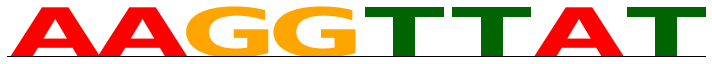

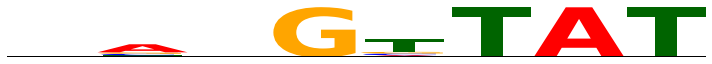

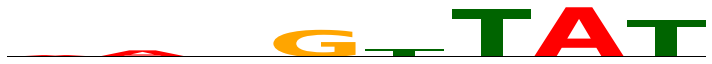

Test sequence 579:
 - Prediction (original) = 15.2
 - Predictions (scrambled) = [13.9, 13.5, 13.4, 13.5, 14.4, 11.5, 12.9, 12.5, 13.3, 14.8, 14.9, 12.7, 11.5, 12.5, 14.9, 11.4, 19.5, 10.7, 14.1, 13.6, 14.5, 6.41, 10.8, 13.2, 13.9, 13.7, 14.5, 14.2, 12.5, 11.1, 13.3, 11.6]


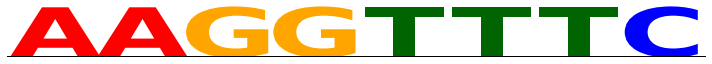

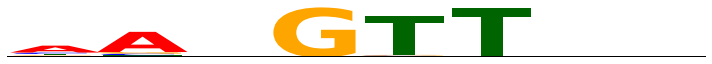

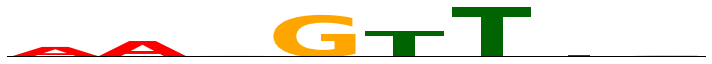

Test sequence 438:
 - Prediction (original) = 6.97
 - Predictions (scrambled) = [4.78, 4.99, 3.53, 4.99, 7.59, 4.87, 6.11, 1.69, 4.07, 7.85, 4.11, 2.12, 5.42, 5.64, 6.66, 5.39, 6.13, 4.35, 4.34, 7.93, 5.48, 4.66, 9.74, 4.28, 9.94, 4.74, 4.81, 1.17, 6.29, 6.05, 3.22, 6.06]


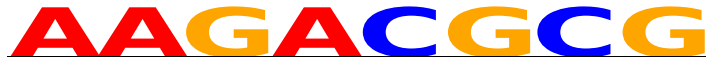

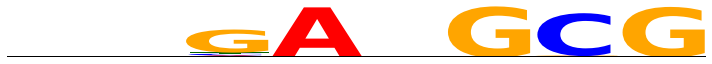

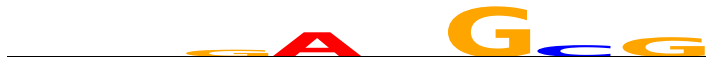

Test sequence 439:
 - Prediction (original) = 16.7
 - Predictions (scrambled) = [14.6, 14.9, 16.4, 15.7, 9.49, 12.9, 14.8, 13.7, 15.8, 15.9, 9.29, 17.1, 15.4, 14.8, 14.6, 12.8, 11.9, 11.9, 15.1, 14.7, 13.2, 12.1, 13.8, 8.88, 9.87, 10.9, 11.6, 14.0, 13.4, 15.2, 16.0, 12.9]


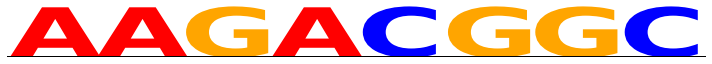

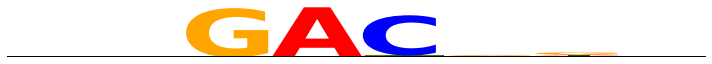

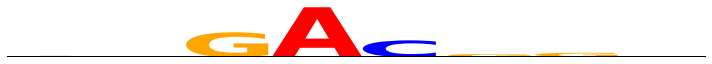

In [27]:
# #Visualize a few reconstructed sequence patterns

# plot_examples = np.arange(5).tolist()
# save_examples = []

# importance_scores_test *= sequence_mask[None, None, :, None]

# for test_ix in ixs :
#     seq = x_test2[test_ix:test_ix+1, ...].flatten().reshape(1,-1)
# #        res = k_reload.predict(seq.flatten().reshape(1,-1))

#     print("Test sequence " + str(test_ix) + ":")
    
#     sample_seqs = sample_test[test_ix, ...]
#     # reshape
#     sample_seqs = np.array([x.flatten().reshape(1,-1) for x in sample_seqs])
    
# #     y_test_hat_ref = k_reload.predict(x=[seq], batch_size=1)[0, 0]
# #     y_test_hat = k_reload.predict(x=[sample_seqs], batch_size=32)[:32, 0].tolist()
#     y_test_hat_ref = k_reload.predict(x=[seq])[0, 0]
#     y_test_hat = [k_reload.predict(x=[ss])[0, 0] for ss in sample_seqs]
# #     print("y_test_hat_ref",y_test_hat_ref)
# #     print("y_test_hat",y_test_hat)
    
#     print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])
#     print(" - Predictions (scrambled) = " + str([float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat))]))
    
#     save_figs = False
#     if save_examples is not None and test_ix in save_examples :
#         save_figs = True
    
#     plot_dna_logo(x_test2[test_ix, 0, :, :], sequence_template=sequence_template, figsize=(10, 1), plot_start=0, plot_end=SEQ_LEN, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_orig_sequence")
#     plot_dna_logo(pwm_test[test_ix, 0, :, :], sequence_template=sequence_template, figsize=(10, 1), plot_start=0, plot_end=SEQ_LEN, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scrambld_pwm")
#     plot_dna_importance_scores(importance_scores_test[test_ix, 0, :, :].T, encoder.decode(x_test2[test_ix, 0, :, :]), figsize=(10, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=SEQ_LEN, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scores")
  

[[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]]]
(1, 8, 4)
Test sequence 4:
 - Prediction (original) = 18.6
 - Predictions (scrambled) = [17.8, 15.9, 22.7, 16.5, 17.3, 13.9, 15.8, 15.6, 13.4, 17.0, 15.7, 16.0, 14.6, 13.6, 17.0, 12.3, 15.7, 15.4, 15.0, 15.8, 16.2, 16.6, 15.9, 15.1, 15.1, 16.7, 8.44, 15.4, 16.4, 14.7, 16.5, 13.8]


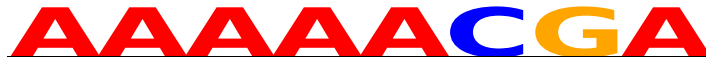

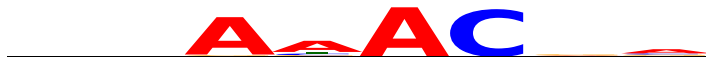

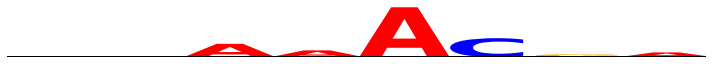

[[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]]
(1, 8, 4)
Test sequence 133:
 - Prediction (original) = 8.08
 - Predictions (scrambled) = [12.6, 13.5, 11.1, 13.1, 9.49, 8.32, 2.35, 12.6, 16.2, 13.1, 9.08, 11.6, 9.02, 3.59, 6.92, 6.88, 6.47, 8.21, 9.7, 5.13, 8.27, 7.86, -0.0, 8.24, 10.0, 11.7, 8.11, 6.18, 9.92, 4.54, 8.37, 7.63]


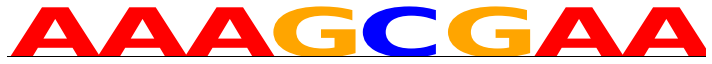

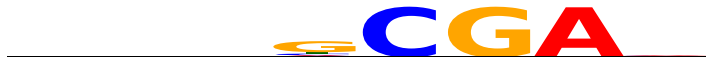

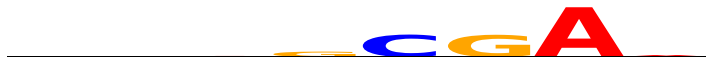

[[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 0. 1.]
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]
  [0. 1. 0. 0.]]]
(1, 8, 4)
Test sequence 97:
 - Prediction (original) = 26.1
 - Predictions (scrambled) = [24.6, 24.1, 25.1, 25.2, 23.8, 24.3, 25.2, 24.5, 24.4, 24.6, 25.1, 24.2, 23.8, 24.8, 25.2, 24.5, 25.4, 24.7, 24.4, 23.7, 25.6, 25.5, 25.4, 25.3, 23.8, 25.0, 23.4, 23.5, 24.5, 25.2, 24.3, 24.9]


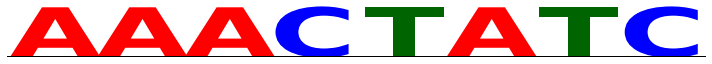

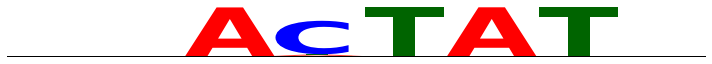

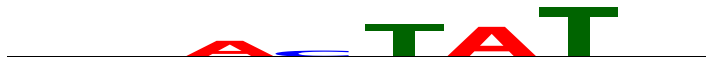

[[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 0. 1.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]]
(1, 8, 4)
Test sequence 99:
 - Prediction (original) = 18.2
 - Predictions (scrambled) = [15.0, 15.9, 14.6, 16.4, 17.0, 17.5, 16.2, 16.2, 14.2, 17.6, 17.1, 17.1, 16.8, 15.6, 15.5, 16.1, 15.2, 16.2, 17.0, 17.8, 16.2, 17.5, 16.1, 16.0, 16.4, 15.6, 16.4, 15.7, 14.4, 17.1, 16.6, 16.8]


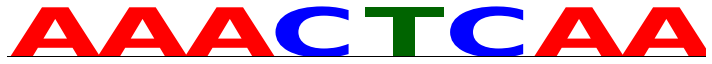

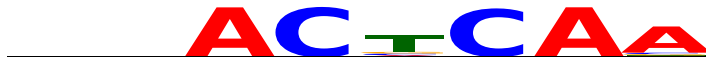

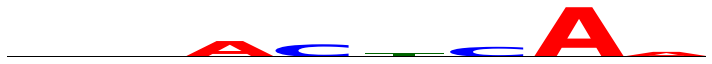

[[[0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]]]
(1, 8, 4)
Test sequence 13074:
 - Prediction (original) = 20.8
 - Predictions (scrambled) = [23.1, 26.6, 27.6, 21.3, 23.5, 23.7, 23.8, 23.8, 24.7, 28.2, 24.7, 15.0, 22.6, 29.1, 25.5, 24.1, 24.4, 20.6, 27.8, 25.1, 22.5, 23.5, 23.0, 23.1, 26.5, 16.1, 23.3, 25.5, 27.2, 24.8, 23.1, 24.0]


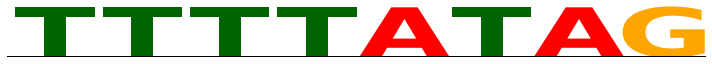

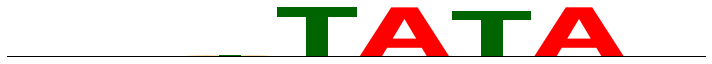

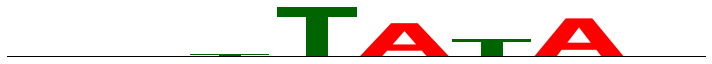

[[[0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]]]
(1, 8, 4)
Test sequence 13075:
 - Prediction (original) = 13.4
 - Predictions (scrambled) = [17.6, 14.8, 13.6, 16.6, 14.2, 17.0, 15.6, 11.6, 15.8, 15.7, 15.8, 9.71, 15.5, 9.37, 13.7, 14.2, 14.8, 15.7, 13.6, 21.8, 12.6, 15.7, 6.89, 16.3, 14.0, 12.8, 10.6, 16.3, 15.0, 12.4, 4.47, 9.62]


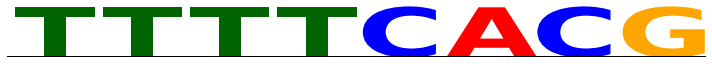

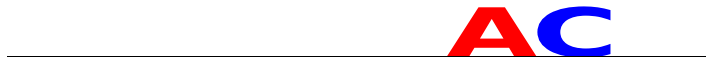

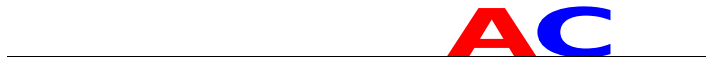

[[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]]]
(1, 8, 4)
Test sequence 578:
 - Prediction (original) = 25.0
 - Predictions (scrambled) = [22.2, 23.6, 22.7, 21.2, 25.6, 23.7, 20.3, 25.8, 24.0, 23.0, 17.3, 23.0, 23.8, 25.8, 22.5, 20.0, 22.8, 22.6, 20.6, 21.9, 20.5, 19.4, 23.8, 20.7, 21.6, 24.5, 22.9, 22.9, 21.2, 22.4, 23.7, 22.0]


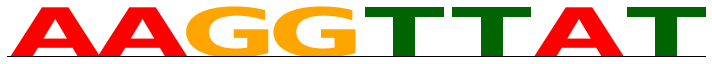

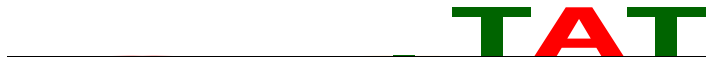

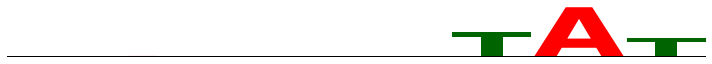

[[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 1. 0. 0.]]]
(1, 8, 4)
Test sequence 579:
 - Prediction (original) = 15.6
 - Predictions (scrambled) = [14.9, 13.2, 10.7, 11.0, 13.7, 15.2, 14.4, 14.0, 15.0, 14.7, 11.0, 18.6, 12.9, 14.5, 15.8, 14.5, 14.1, 16.5, 15.8, 8.16, 13.1, 15.5, 14.2, 16.5, 14.7, 13.8, 12.4, 11.9, 15.0, 11.7, 12.5, 15.1]


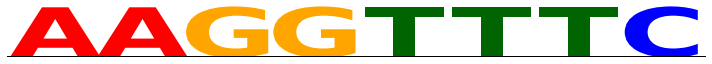

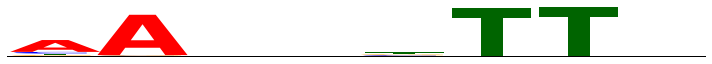

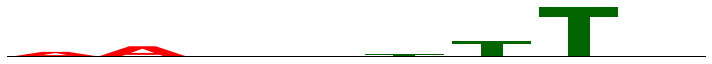

[[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]]]
(1, 8, 4)
Test sequence 438:
 - Prediction (original) = 8.22
 - Predictions (scrambled) = [4.6, 4.3, 11.4, 6.39, 8.53, 6.42, 9.39, 7.28, 8.64, 7.07, 6.13, 3.52, 6.78, 4.73, 7.18, 8.49, 14.0, 9.48, 6.46, 14.3, 6.11, 6.7, 10.1, 5.93, 7.27, 7.02, 9.24, 8.76, 8.14, 7.76, 6.45, 7.63]


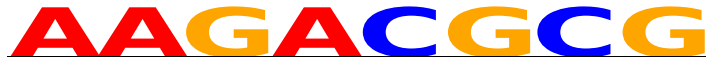

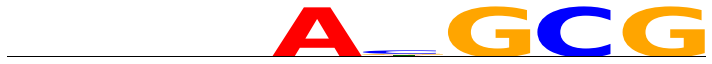

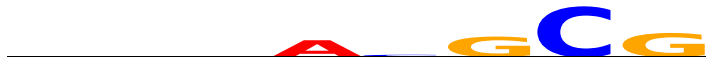

[[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]]]
(1, 8, 4)
Test sequence 439:
 - Prediction (original) = 17.0
 - Predictions (scrambled) = [13.7, 15.4, 14.2, 14.0, 11.6, 15.4, 15.6, 14.6, 14.3, 13.7, 16.0, 13.4, 15.5, 13.2, 11.8, 13.4, 11.9, 13.0, 14.4, 14.4, 14.4, 15.4, 10.1, 13.0, 13.4, 17.3, 13.8, 14.5, 16.7, 15.9, 15.5, 15.6]


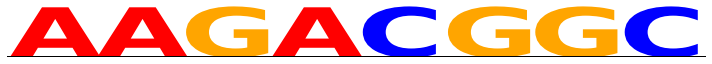

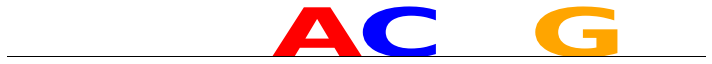

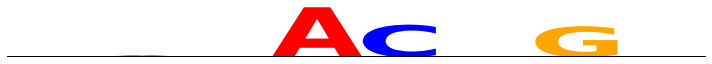

In [30]:
#Visualize a few reconstructed sequence patterns

plot_examples = np.arange(5).tolist()
save_examples = []

importance_scores_test *= sequence_mask[None, None, :, None]

for test_ix in ixs :
    #seq = x_test2[test_ix:test_ix+1, ...].flatten().reshape(1,-1)
    seq = x_test2[test_ix:test_ix+1, ...][0]#.reshape(1,-1)
    # WWHYYY IS THIS SHAPE WRONG?!?!?
    
    print(seq)
    print(seq.shape)
#        res = k_reload.predict(seq.flatten().reshape(1,-1))

    print("Test sequence " + str(test_ix) + ":")
    
    sample_seqs = sample_test[test_ix, ...]
    # reshape
    #sample_seqs = np.array([x.flatten().reshape(1,-1) for x in sample_seqs])
    
#     y_test_hat_ref = k_reload.predict(x=[seq], batch_size=1)[0, 0]
#     y_test_hat = k_reload.predict(x=[sample_seqs], batch_size=32)[:32, 0].tolist()
    y_test_hat_ref = k_reload.predict(x=[seq])[0, 0]
    y_test_hat = [k_reload.predict(x=[ss])[0, 0] for ss in sample_seqs]
#     print("y_test_hat_ref",y_test_hat_ref)
#     print("y_test_hat",y_test_hat)
    
    print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])
    print(" - Predictions (scrambled) = " + str([float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat))]))
    
    save_figs = False
    if save_examples is not None and test_ix in save_examples :
        save_figs = True
    
    plot_dna_logo(x_test2[test_ix, 0, :, :], sequence_template=sequence_template, figsize=(10, 1), plot_start=0, plot_end=SEQ_LEN, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_orig_sequence")
    plot_dna_logo(pwm_test[test_ix, 0, :, :], sequence_template=sequence_template, figsize=(10, 1), plot_start=0, plot_end=SEQ_LEN, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scrambld_pwm")
    plot_dna_importance_scores(importance_scores_test[test_ix, 0, :, :].T, encoder.decode(x_test2[test_ix, 0, :, :]), figsize=(10, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=SEQ_LEN, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scores")
  